In [1]:
from utils_synthetic import *
from scipy.special import binom as spb
from matplotlib import cm
from sklearn.neighbors import NearestNeighbors
from scipy.integrate import quad as spq
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

In [ ]:
def make_distance_empirical_cdf(index, nn_dists_array):
    
    #nn_dist_array = np.sort(nn_dist_array)
    
    B, N = nn_dists_array.shape
    
    def distance(x):
        
        score = np.sum(nn_dists_array <= x, axis = 1)/N
        score_0 = score[index]
        score_1 = (score.sum()-score_0)/(B-1)
        dist = (score_1-score_0)**2
        return dist
    
    return distance

In [ ]:
def draw_gaussian_mixture_model(N, D, K, pis, mus, sigmas, seed = 0):
    np.random.seed(seed)
    data = np.zeros([N,D])
    N_ks = np.zeros(K)
    N_total = 0
    labels = np.zeros(N)
    for p, pi in enumerate(pis[:-1]):
        #print(pi)
        if N_total < N:
            #print(p)
            N_k = np.random.binomial(N, pi)
            #print(N_k)
            N_ks[p] = N_k
            if N_total+N_k>N:
                N_k = N-N_total
            sample = np.random.multivariate_normal(mean = mus[p], cov = sigmas[p], size = N_k)
            data[N_total:N_total+N_k] = sample
            labels[N_total:N_total+N_k] = p
            N_total+=N_k
    if N_total<N:
        N_k = N-N_total
        data[N_total:] = np.random.multivariate_normal(mean = mus[-1], cov = sigmas[-1], size = N_k)
        N_ks[-1] = N_k
        labels[N_total:N_total+N_k] = K-1
    return data, labels.astype(int)

In [ ]:
num_boots = 200
N, D = int(1e4), 5
results_test = {}
base_sigma = .2
for K in [1,2,3,5]:
    results_test[K] = {}
    pis = [1/K for k in range(K)]
    mus = np.random.multivariate_normal(np.zeros(D), np.eye(D), size = K)
    sigmas = [base_sigma*np.eye(D) for k in range(K)]
    data, labels = draw_gaussian_mixture_model(N, D, K, pis, mus, sigmas)
    results_test[K]['data'] = data
    results_test[K]['labels'] = labels
    
    c_ls = cm.gist_ncar_r(np.linspace(.2, 1, K))
    results_test[K]['colors'] = c_ls

    plt.figure(figsize = (8,3))
    plt.scatter(data[:,0], data[:,1], color = [c_ls[lab] for lab in labels], s = 2)
    plt.show()
    
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(data)
    distances, indices = nbrs.kneighbors(data)
    results_test[K]['true_distances'] = distances[:,1]
    
    mu = data.mean(axis = 0)
    cov = np.cov(data.T)
    results_test[K]['distances'] = np.zeros([num_boots+1, N])
    results_test[K]['distances'][0] = distances[:,1]
    results_test[K]['null_data'] = np.zeros([num_boots, N, D])
    print('Drawing synthetic data...')
    for seed in tqdm_notebook(range(num_boots)):
        # generate data from null model
        null_data = np.random.multivariate_normal(mean = mu, cov = cov, size = N)
        nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(null_data)
        distances, indices = nbrs.kneighbors(null_data)
        results_test[K]['null_data'][seed] = null_data
        results_test[K]['distances'][seed+1] = distances[:,1]
    ub = np.max(results_test[K]['distances'])    
    results_test[K]['score'] = np.zeros(num_boots+1)
    print('Computing test scores...')
    for seed in tqdm_notebook(range(num_boots+1)):
        dd = make_distance_empirical_cdf(seed, results_test[K]['distances'])
        results_test[K]['score'][seed] = spq(dd,0,ub)[0]
np.save('Additional_Experiments/test_scores', results_test)

mini_test_scores = {}
for k in test_scores:
    mini_test_scores[k] = {}
    mini_test_scores[k]['data'] = test_scores[k]['data']
    mini_test_scores[k]['colors'] = test_scores[k]['colors']
    mini_test_scores[k]['score'] = test_scores[k]['score']
np.save('Additional_Experiments/mini_test_scores', mini_test_scores)

In [ ]:
num_boots = 1000
N, D = int(5e2), 2
results_test = {}
base_sigma = .2
for K in [1,2,3,5]:
    results_test[K] = {}
    pis = [1/K for k in range(K)]
    mus = np.random.multivariate_normal(np.zeros(D), np.eye(D), size = K)
    sigmas = [base_sigma*np.eye(D) for k in range(K)]
    data, labels = draw_gaussian_mixture_model(N, D, K, pis, mus, sigmas)
    results_test[K]['data'] = data
    results_test[K]['labels'] = labels
    
    c_ls = cm.gist_ncar_r(np.linspace(.2, 1, K))
    results_test[K]['colors'] = c_ls

    plt.figure(figsize = (8,3))
    plt.scatter(data[:,0], data[:,1], color = [c_ls[lab] for lab in labels], s = 2)
    plt.show()
    
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(data)
    distances, indices = nbrs.kneighbors(data)
    results_test[K]['true_distances'] = distances[:,1]
    
    mu = data.mean(axis = 0)
    cov = np.cov(data.T)
    results_test[K]['distances'] = np.zeros([num_boots+1, N])
    results_test[K]['distances'][0] = distances[:,1]
    results_test[K]['null_data'] = np.zeros([num_boots, N, D])
    print('Drawing synthetic data...')
    for seed in tqdm(range(num_boots)):
#         # generate data from null model
        null_data = np.random.multivariate_normal(mean = mu, cov = cov, size = N)
        nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(null_data)
        distances, indices = nbrs.kneighbors(null_data)
        results_test[K]['null_data'][seed] = null_data
        results_test[K]['distances'][seed+1] = distances[:,1]
    ub = np.max(results_test[K]['distances'])    
    results_test[K]['score'] = np.zeros(num_boots+1)
    print('Computing test scores...')
    for seed in tqdm(range(num_boots+1)):
        dd = make_distance_empirical_cdf(seed, results_test[K]['distances'])
        results_test[K]['score'][seed] = spq(dd,0,ub)[0]
np.save('Additional_Experiments/test_scores_2', results_test)

test_scores = np.load('Additional_Experiments/test_scores_2.npy', allow_pickle=1).item()

mini_test_scores_2 = {}
for k in test_scores:
    mini_test_scores_2[k] = {}
    mini_test_scores_2[k]['data'] = test_scores[k]['data']
    mini_test_scores_2[k]['colors'] = test_scores[k]['colors']
    mini_test_scores_2[k]['score'] = test_scores[k]['score']
np.save('Additional_Experiments/mini_test_scores_2', mini_test_scores_2)

In [ ]:
# num_boots = 1000
# N, D = int(5e2), 2
# results_test = {}
# mean_distances = [2,1,.5,.25,.1]
# K=2
# base_sigma = .25
# pis = [1/K for k in range(K)]
# for mean_distance in mean_distances:
#     results_test[mean_distance] = {}
#     diag = [np.sqrt(mean_distance/2), np.sqrt(mean_distance/2)]
#     mus = np.array([np.zeros(2), np.array(diag)])
#     sigmas = [base_sigma*np.eye(D) for k in range(K)]
#     data, labels = draw_gaussian_mixture_model(N, D, K, pis, mus, sigmas)
#     results_test[mean_distance]['data'] = data
#     results_test[mean_distance]['labels'] = labels
    
#     c_ls = cm.gist_ncar_r(np.linspace(.2, 1, K))
#     results_test[mean_distance]['colors'] = c_ls

#     plt.figure(figsize = (8,3))
#     plt.scatter(data[:,0], data[:,1], color = [c_ls[lab] for lab in labels], s = 2)
#     plt.show()
    
#     nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(data)
#     distances, indices = nbrs.kneighbors(data)
#     results_test[mean_distance]['true_distances'] = distances[:,1]
    
#     mu = data.mean(axis = 0)
#     cov = np.cov(data.T)
#     results_test[mean_distance]['distances'] = np.zeros([num_boots+1, N])
#     results_test[mean_distance]['distances'][0] = distances[:,1]
#     results_test[mean_distance]['null_data'] = np.zeros([num_boots, N, D])
#     print('Drawing synthetic data...')
#     for seed in tqdm(range(num_boots)):
# #         # generate data from null model
#         null_data = np.random.multivariate_normal(mean = mu, cov = cov, size = N)
#         nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(null_data)
#         distances, indices = nbrs.kneighbors(null_data)
#         results_test[mean_distance]['null_data'][seed] = null_data
#         results_test[mean_distance]['distances'][seed+1] = distances[:,1]
#     ub = np.max(results_test[mean_distance]['distances'])    
#     results_test[mean_distance]['score'] = np.zeros(num_boots+1)
#     print('Computing test scores...')
#     for seed in tqdm(range(num_boots+1)):
#         dd = make_distance_empirical_cdf(seed, results_test[mean_distance]['distances'])
#         results_test[mean_distance]['score'][seed] = spq(dd,0,ub)[0]
# np.save('Additional_Experiments/test_scores_distance', results_test)

test_scores = np.load('Additional_Experiments/test_scores_distance.npy', allow_pickle=1).item()

mini_test_scores_dist = {}
for k in test_scores:
    mini_test_scores_dist[k] = {}
    mini_test_scores_dist[k]['data'] = test_scores[k]['data']
    mini_test_scores_dist[k]['colors'] = test_scores[k]['colors']
    mini_test_scores_dist[k]['score'] = test_scores[k]['score']
    mini_test_scores_dist[k]['labels'] = test_scores[k]['labels']

np.save('Additional_Experiments/mini_test_scores_distance', mini_test_scores_dist)

### NOW PLOTTING

In [2]:
from utils_synthetic import *
from scipy.special import binom as spb
from matplotlib import cm
from sklearn.neighbors import NearestNeighbors
from scipy.integrate import quad as spq
from sklearn.decomposition import PCA
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


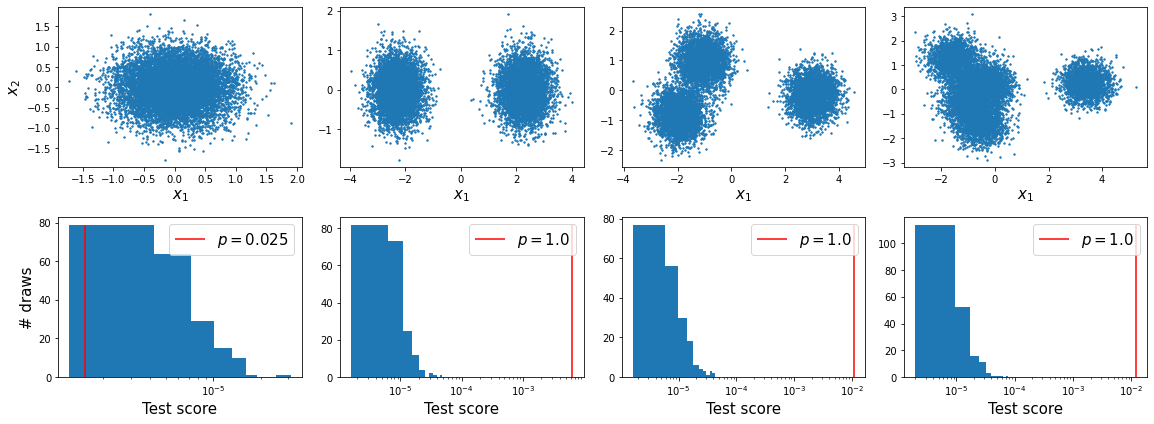

In [3]:
test_scores = np.load('Additional_Experiments/mini_test_scores.npy', allow_pickle=1).item()
plt.figure(figsize = (16,6))
kz = len(test_scores)
for k, key in enumerate(test_scores.keys()):
    
    pca = PCA(n_components=2)
    mini = pca.fit_transform(test_scores[key]['data'])
    PCA(n_components=2)
    
    plt.subplot(2,kz,k+1)
    plt.scatter(mini[:,0], mini[:,1], s= 2)
    plt.xlabel(r'$x_1$', fontsize = 15)
    if k == 0:
        plt.ylabel(r'$x_2$', fontsize = 15)
    plt.subplot(2,kz,kz+k+1)
    if k == 0:
        plt.ylabel('# draws', fontsize = 15)
    y,x,_ = plt.hist(test_scores[key]['score'][1:], density=0)
    sc = np.sum(test_scores[key]['score'][0]>=test_scores[key]['score'][1:])/len(test_scores[key]['score'][1:])
    plt.vlines(x = test_scores[key]['score'][0], ymin = 0, ymax = max(y), color = 'r', label = r'$p = $'+str(sc))
    plt.xlabel(r'Test score', fontsize = 15)
    plt.legend(fontsize = 15)
    plt.xscale('log')
plt.tight_layout()
# plt.savefig('Plots/Test_k1.pdf', bbox_inches = 'tight', dpi = 1000)
plt.show()

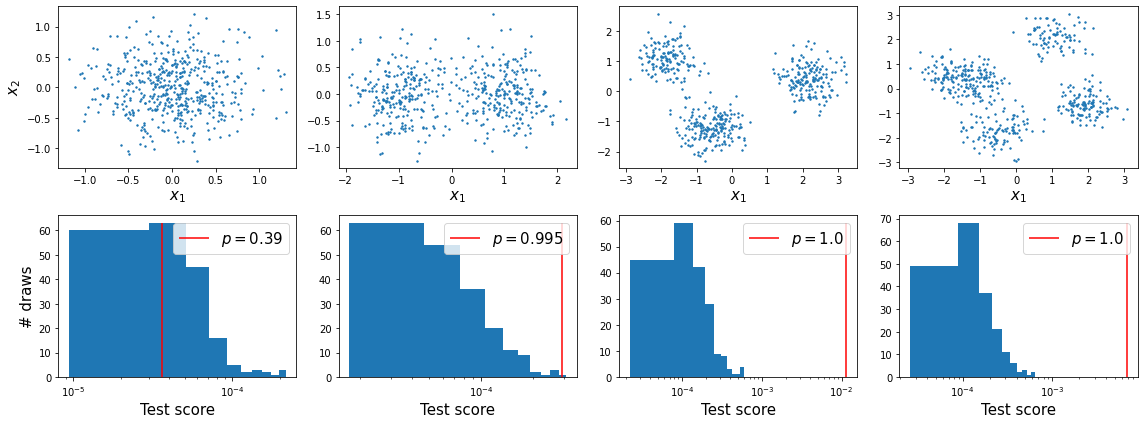

In [4]:
test_scores = np.load('Additional_Experiments/mini_test_scores_2.npy', allow_pickle=1).item()

plt.figure(figsize = (16,6))
kz = len(test_scores)
for k, key in enumerate(test_scores.keys()):
    
    pca = PCA(n_components=2)
    mini = pca.fit_transform(test_scores[key]['data'])
    PCA(n_components=2)
    
    plt.subplot(2,kz,k+1)
    plt.scatter(mini[:,0], mini[:,1], s= 2)
    plt.xlabel(r'$x_1$', fontsize = 15)
    if k == 0:
        plt.ylabel(r'$x_2$', fontsize = 15)
    plt.subplot(2,kz,kz+k+1)
    if k == 0:
        plt.ylabel('# draws', fontsize = 15)
    
    y,x,_ = plt.hist(test_scores[key]['score'][1:], density=0)
    sc = np.sum(test_scores[key]['score'][0]>=test_scores[key]['score'][1:])/len(test_scores[key]['score'][1:])
    plt.vlines(x = test_scores[key]['score'][0], ymin = 0, ymax = max(y), color = 'r', label = r'$p = $'+str(sc))
    plt.xlabel(r'Test score', fontsize = 15)
    plt.legend(fontsize = 15)

    plt.xscale('log')
plt.tight_layout()
# plt.savefig('Plots/Test_k2.pdf', bbox_inches = 'tight', dpi = 1000)
plt.show()

In [6]:
test_scores = np.load('Additional_Experiments/mini_test_scores_distance.npy', allow_pickle=1).item()

plt.figure(figsize = (16,6))
kz = len(test_scores)
for k, distance in enumerate(test_scores.keys()):
#     print(distance)

    labels = test_scores[distance]['labels']
    c_ls = test_scores[distance]['colors']
    plt.subplot(2,kz,k+1)
    plt.scatter(test_scores[distance]['data'][:,0], test_scores[distance]['data'][:,1], color = [c_ls[lab] for lab in labels], s= 2)
    plt.xlabel(r'$x_1$', fontsize = 15)
    plt.title(r'$d(\mu_1, \mu_2)=$'+str(distance), fontsize = 15)
    if k == 0:
        plt.ylabel(r'$x_2$', fontsize = 15)
    ax = plt.subplot(2,kz,kz+k+1)
    if k == 0:
        plt.ylabel('# draws', fontsize =15)
    y,x,_ = plt.hist(test_scores[distance]['score'][1:], density=0)
    sc = np.sum(test_scores[distance]['score'][0]>=test_scores[distance]['score'][1:])/len(test_scores[distance]['score'][1:])
    plt.vlines(x = test_scores[distance]['score'][0], ymin = 0, ymax = max(y), color = 'r', label = r'$p = $'+str(sc))
    plt.legend(fontsize = 15)
    plt.xlabel(r'Test score', fontsize = 20)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#     plt.xscale('log')
plt.tight_layout()
# plt.savefig('Plots/Test_distance.pdf', bbox_inches = 'tight', dpi = 1000)
plt.show()

KeyError: 'labels'

<Figure size 1152x432 with 0 Axes>